In [19]:
import got
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
import collections
import urllib2
from bs4 import BeautifulSoup
from bs4 import NavigableString

In [15]:
df = pd.read_csv('output_got7.csv', delimiter='\t', quotechar='"')

In [3]:
text = df['text']
text = text.str.decode('utf-8')

In [20]:
def buildSlangDictionary():
    alpha = list(map(chr, range(ord('a'), ord('z')+1)))
    url = 'http://www.noslang.com/dictionary/'
    headers = {
        'User-Agent': "Mozilla/5.0 (Windows NT 6.1; Win64; x64)",
        'Accept': "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        'Accept-Language': "de,en-US;q=0.7,en;q=0.3",
        'Accept-Charset': "ISO-8859-1,utf-8;q=0.7,*;q=0.3",
        'Accept-Encoding': 'none',
        'Connection': "keep-alive"
    }
    slang_dict = collections.defaultdict(str)
    for letter in alpha:
        url = url + letter + '/'
        req = urllib2.Request(url, headers=headers)
        response = urllib2.urlopen(req)
        soup = BeautifulSoup(response)
        abbr_list = []
        for abbr in soup.findAll('abbr'):
            abbr_list.append(abbr)
        for x in abbr_list:
            temp = x.contents[0].contents[0].contents
            if isinstance(temp[0], NavigableString):
                slang = ''.join(temp)
                slang = slang.encode('ascii', 'ignore')
                slang = slang.split(' :')[0]
                meaning = x['title']
                slang_dict[slang] = meaning
        url = url[:-2]
    return slang_dict

In [71]:
def clean_tweet(tweet, slang_dict):
    #remove urls
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'pic.twitter\S+', '', tweet)
    
    #remove hashtags and mentions
    tweet = re.sub(r'#\S+', '', tweet)
    tweet = re.sub(r'@\S+', '', tweet)
    
    #Remove stop-words and punctuation
    stopset = stopwords.words('english') + list(string.punctuation)
        
    tokeniser = TweetTokenizer()
    tweet_tokens = tokeniser.tokenize(tweet.lower())
    tokens = [i for i in tweet_tokens if i not in stopset and len(i) > 2]

     
    #Stemming
    #porter_stemmer = PorterStemmer()
    #tokens = [porter_stemmer.stem(token) for token in tokens]
    
    #Lemmanisation
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    
    #Slang lookup
    tweet_tokens = []
    
    for i in range(len(tokens)):
        if tokens[i] in slang_dict:
            abbrev = slang_dict[tokens[i]].split()
            abbrev = [j for j in abbrev if j not in stopset and len(j)>2]
            tweet_tokens.append(abbrev)
        else:
            tweet_tokens.append(tokens[i])
    del tokens
            
    return tweet_tokens

    
    

In [73]:
slang_dict = buildSlangDictionary()


In [74]:

text_clean = text.apply(clean_tweet,args=(slang_dict,))

In [31]:
#Remove non-english tweets

#Remove tweets having less then 3 tokens
indexes = []
for i in range(len(text_clean)):
    if len(text_clean[i]) < 3:
        indexes.append(i)
    else:
        text_clean[i] = ' '.join(text_clean[i])
        
text_clean.drop(indexes, inplace=True)
del indexes

In [62]:
print text

0        ‡§ö‡§ø‡§™ ‡§®‡§π‡•Ä‡§Ç ‡§´‡§ø‡§∞ ‡§ï‡•à‡§∏‡•á ...
1        ‡§ö‡§ø‡§™ ‡§®‡§π‡•Ä‡§Ç ‡§´‡§ø‡§∞ ‡§ï‡•à‡§∏‡•á ...
2        #DeMonetisation and it's effect on Karnataka. ...
3        One Month In, What's The Impact Of India's #De...
4        One good thing from #demonetization: We know t...
5        Delhi CM #ArvindKejriwal‚Äã criticise govt's #...
6        #Demonetization. SHORT TERM PAIN LONG TERM GAI...
7        @kapsology @ArvindKejriwal pehle isko spelling...
8        Ye to hona he tha,Amit Shah loses temper at BJ...
9        PM's Silence speaks louder than his Rhetoric. ...
10       ‡§Æ‡•ã‡§¶‡•Ä ‡§ú‡•Ä ‡§¨‡§∏ ‡§Ö‡§¨ ‡§¨‡•à‡§ï‡§´...
11       ‡Æ™‡ØÅ‡Æ§‡Æø‡ÆØ ‡Æ∞‡ØÇ.500 ‡Æ®‡Øã‡Æü‡Øç‡Æü‡ØÅ‡...
12       ‡§Æ‡•ã‡§¶‡•Ä ‡§ú‡•Ä ‡§¨‡§∏ ‡§Ö‡§¨ ‡§¨‡•à‡§ï‡§´...
13       Where is he gonna put all the Hookahs? #Hookah...
14       The latest The Honest Frank Daily! http://pape...
15       #Demonetisation #SC #Bjp ‡Æí‡Æ∞‡ØÅ ‡Æö‡Æø‡Æ≤‡Æ...
16       .@timesofindia Can Nation know from #SC that H.

In [60]:
sample = text_clean.sample(1000)
len(sample)

1000

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

/usr/local/lib/python2.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [54]:
sid = SentimentIntensityAnalyzer()
tweets = pd.DataFrame(sample, columns=['text'], dtype=str)
tweets['sentiment_compound_polarity']=tweets.text.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text.apply(lambda x:sid.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

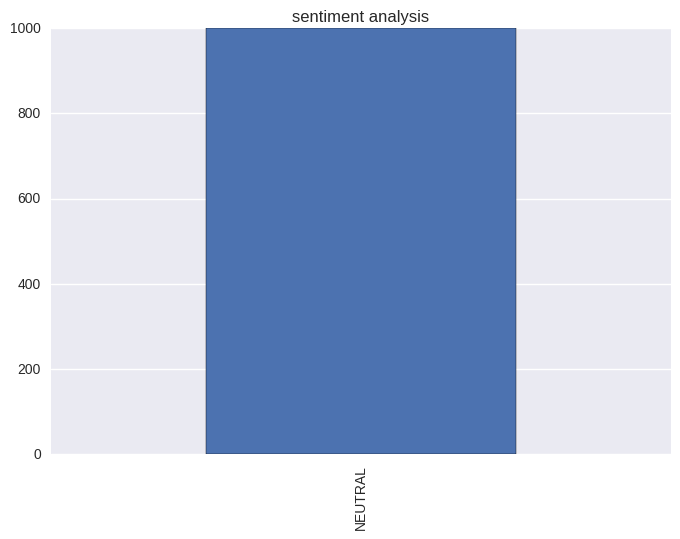

In [55]:
import matplotlib.pyplot as plt
tweets.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")
plt.show()

## Topic Modeling

In [56]:
import gensim
from gensim import corpora

In [66]:
x = tweets['text']
print x
dictionary = corpora.Dictionary(x)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in x]

67304    [ u ' j a i t l e y ' ,   u ' w a n t ' ,   u ...
54203    [ u ' t w e e t e d ' ,   u ' d a y ' ,   u ' ...
34009    [ u ' l o o k ' ,   u ' l i k e ' ,   u " o n ...
64592    [ u ' a p p r e c i a t e d ' ,   u ' o b v i ...
23870    [ u ' k u c h ' ,   u ' m e e t h a ' ,   u ' ...
60858    [ u ' j o k e ' ,   u ' m o d i ' ,   u ' n e ...
9285     [ u ' o p p o s i t i o n ' ,   u ' p a r t y ...
60285    [ u ' e q u e l ' ,   u ' m a k e ' ,   u ' m ...
55822    [ u ' o n e ' ,   u ' o n e ' ,   u ' c o r r ...
32746    [ u ' c o u n t r y ' ,   u ' c a s h l e s s ...
30514    [ u ' i n c i n d i a ' ,   u ' t e r m ' ,   ...
33295    [ u ' m a j o r ' ,   u ' w i t h d r a w a l ...
56068    [ u ' a s s a s s i n a t i o n ' ,   u ' m e ...
60005    [ u ' k y o ' ,   u ' s u s u ' ,   u ' g y i ...
64258    [ u ' b i g g e s t ' ,   u ' a c h i e v e m ...
27912    [ u ' s a y ' ,   u ' l o o k ' ,   u " w h o ...
62739    [ u ' l e a d e r ' ,   u ' g o v e r n m e n .

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [10]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

In [17]:
ldamodel.per_word_topics

False